In [1]:
%matplotlib inline

Automatically created module for IPython interactive environment


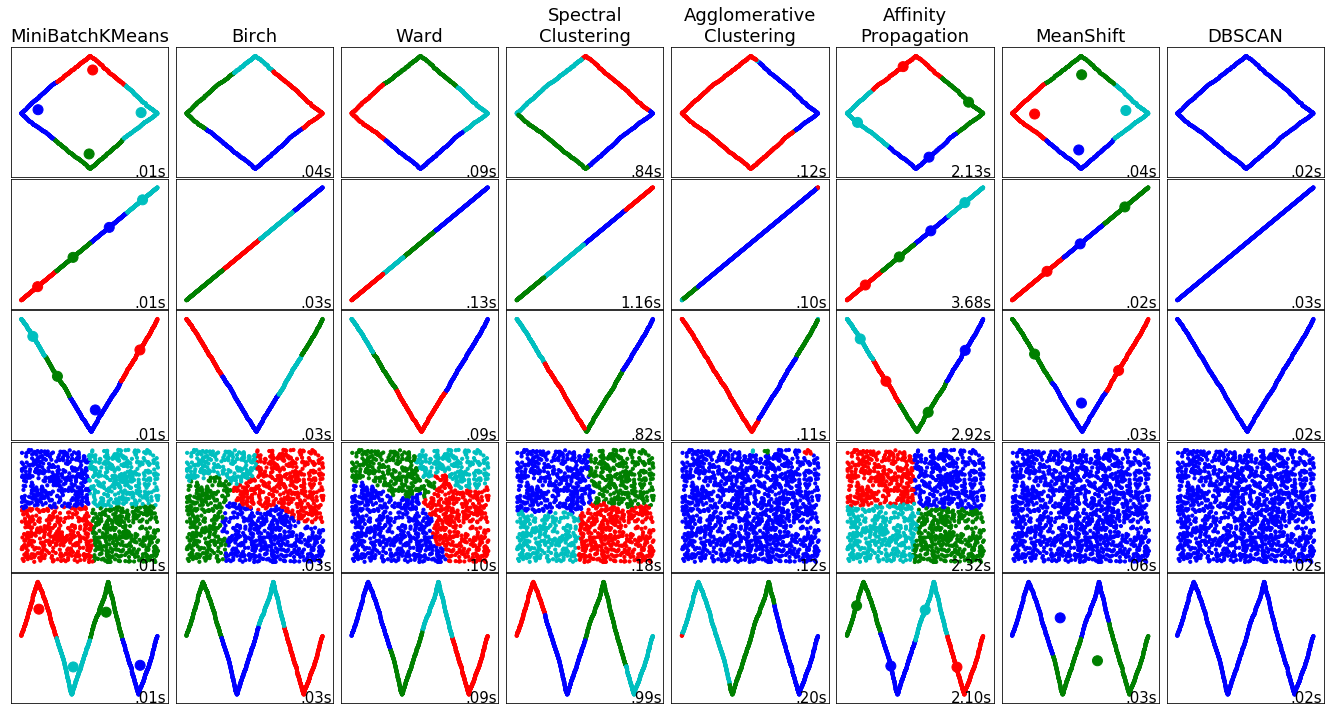

In [2]:
print(__doc__)

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# import library to compute pseudo-observations
import sys
sys.path.append('..')
from rdc import pobs

np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
#noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
#                                      noise=.05)

# define the circular dependency
x = np.random.uniform(size=(n_samples,1))
y = (2*np.random.binomial(1,0.5,size=(n_samples,1))-1)*(np.sqrt(1 - np.power((2*x - 1),2)))
u = pobs(x)
v = pobs(y)
circular_dep = np.concatenate((u,v),axis=1)

# define the linear dependency
x = np.random.uniform(size=(n_samples,1))
y = x
u = pobs(x)
v = pobs(y)
linear_dep = np.concatenate((u,v),axis=1)

# define the quadratic dependency
x = np.random.uniform(size=(n_samples,1))
y = 4*np.power(x-0.5,2)
u = pobs(x)
v = pobs(y)
quadratic_dep = np.concatenate((u,v),axis=1)

# define independence
no_structure = np.random.rand(n_samples, 2)

# sinusoidal dependence
x = np.random.uniform(size=(n_samples,1))
y = np.sin(4*np.pi*x)
u = pobs(x)
v = pobs(y)
sinusoidal_dep = np.concatenate((u,v),axis=1)

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'Birch', 'Ward', 'Spectral\nClustering', 'Agglomerative\nClustering',
    'Affinity\nPropagation', 'MeanShift', 'DBSCAN', ]

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
numClusters = 4

datasets = [circular_dep, linear_dep, quadratic_dep, no_structure, sinusoidal_dep]
for i_dataset, dataset in enumerate(datasets):
    X = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=numClusters)
    ward = cluster.AgglomerativeClustering(n_clusters=numClusters, linkage='ward',
                                           connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=numClusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=numClusters,
        connectivity=connectivity)

    birch = cluster.Birch(n_clusters=numClusters)
    clustering_algorithms = [
        two_means, birch, ward, spectral, average_linkage, 
        affinity_propagation, ms, dbscan]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(5, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()